# E_vs_r_scan - Methodology and code

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import datetime
from copy import deepcopy
from math import floor
from typing import Optional

# http://www.numpy.org/
import numpy as np

# https://ipython.org/
from IPython.display import display, Markdown

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc
from atomman.tools import filltemplate

# https://github.com/usnistgov/iprPy
import iprPy
from iprPy.tools import read_calc_file

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2023-07-31 using iprPy version 0.11.6


Import additional libraries for plotting. The external libraries used are:

- [bokeh](http://bokeh.pydata.org/)

In [2]:
import bokeh
print('Bokeh version =', bokeh.__version__)
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.resources import Resources
from bokeh.io import output_notebook
output_notebook()

Bokeh version = 3.1.1


Loading BokehJS ...

## 1. Load calculation and view description

### 1.1. Load the calculation

In [3]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('E_vs_r_scan')

### 1.2. Display calculation description and theory

In [4]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))

# E_vs_r_scan calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The E_vs_r_scan calculation style calculation creates a plot of the cohesive energy vs interatomic spacing, $r$, for a given atomic system. The system size is uniformly scaled ($b/a$ and $c/a$ ratios held fixed) and the energy is calculated at a number of sizes without relaxing the system. All box sizes corresponding to energy minima are identified.

This calculation was created as a quick method for scanning the phase space of a crystal structure with a given potential in order to identify starting guesses for further structure refinement calculations.

### Version notes

- 2018-07-09: Notebook added.
- 2019-07-30: Description updated and small changes due to iprPy version.
- 2020-05-22: Version 0.10 update - potentials now loaded from database.
- 2020-09-22: Setup and parameter definitions streamlined.
- 2022-03-11: Notebook updated to reflect version 0.11. r_a() function replaced by the atomman.System.r0() method.

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- The minima identified by this calculation do not guarantee that the associated crystal structure will be stable as no relaxation is performed by this calculation. Upon relaxation, the atomic positions and box dimensions may transform the system to a different structure.
- It is possible that the calculation may miss an existing minima for a crystal structure if it is outside the range of $r$ values scanned, or has $b/a$, $c/a$ values far from the ideal.


## Method and Theory

An initial system (and corresponding unit cell system) is supplied. The $r/a$ ratio is identified from the unit cell. The system is then uniformly scaled to all $r_i$ values in the range to be explored and the energy for each is evaluated using LAMMPS and "run 0" command, i.e. no relaxations are performed.

In identifying energy minima along the curve, only the explored values are used without interpolation. In this way, the possible energy minima structures are identified for $r_i$ where $E(r_i) < E(r_{i-1})$ and $E(r_i) < E(r_{i+1})$.


## 2. Define calculation functions and generate files

This section defines the calculation functions and associated resource files exactly as they exist inside the iprPy package.  This allows for the code used to be directly visible and modifiable by anyone looking to see how it works.

### 2.1. e_vs_r_scan()

This is the primary function for the calculation.  The version of this function built in iprPy can be accessed by calling the calc() method of an object of the associated calculation class.

In [5]:
def e_vs_r_scan(lammps_command: str,
                system: am.System,
                potential: am.lammps.Potential,
                mpi_command: Optional[str] = None,
                ucell: Optional[am.System] = None, 
                rmin: float = uc.set_in_units(2.0, 'angstrom'), 
                rmax: float = uc.set_in_units(6.0, 'angstrom'),
                rsteps: int = 200) -> dict:
    """
    Performs a cohesive energy scan over a range of interatomic spaces, r.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    ucell : atomman.System, optional
        The fundamental unit cell correspodning to system.  This is used to
        convert system dimensions to cell dimensions. If not given, ucell will
        be taken as system.
    rmin : float, optional
        The minimum r spacing to use (default value is 2.0 angstroms).
    rmax : float, optional
        The maximum r spacing to use (default value is 6.0 angstroms).
    rsteps : int, optional
        The number of r spacing steps to evaluate (default value is 200).
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'r_values'** (*numpy.array of float*) - All interatomic spacings,
          r, explored.
        - **'a_values'** (*numpy.array of float*) - All unit cell a lattice
          constants corresponding to the values explored.
        - **'Ecoh_values'** (*numpy.array of float*) - The computed cohesive
          energies for each r value.
        - **'min_cell'** (*list of atomman.System*) - Systems corresponding to
          the minima identified in the Ecoh_values.
    """

    # Make system a deepcopy of itself (protect original from changes)
    system = deepcopy(system)
    
    # Set ucell = system if ucell not given
    if ucell is None:
        ucell = system
    
    # Calculate the r/a ratio for the unit cell
    r_a = ucell.r0() / ucell.box.a
    
    # Get ratios of lx, ly, and lz of system relative to a of ucell
    lx_a = system.box.a / ucell.box.a
    ly_a = system.box.b / ucell.box.a
    lz_a = system.box.c / ucell.box.a
    alpha = system.box.alpha
    beta =  system.box.beta
    gamma = system.box.gamma
 
    # Build lists of values
    r_values = np.linspace(rmin, rmax, rsteps)
    a_values = r_values / r_a
    Ecoh_values = np.empty(rsteps)
    
    # Loop over values
    for i in range(rsteps):
        
        # Rescale system's box
        a = a_values[i]
        system.box_set(a = a * lx_a, 
                       b = a * ly_a, 
                       c = a * lz_a, 
                       alpha=alpha, beta=beta, gamma=gamma, scale=True)
        
        # Get lammps units
        lammps_units = lmp.style.unit(potential.units)
        
        # Define lammps variables
        lammps_variables = {}
        system_info = system.dump('atom_data', f='atom.dat',
                                  potential=potential)
        lammps_variables['atomman_system_pair_info'] = system_info
        
        # Write lammps input script
        lammps_script = 'run0.in'
        template = read_calc_file('iprPy.calculation.E_vs_r_scan', 'run0.template')
        with open(lammps_script, 'w') as f:
            f.write(filltemplate(template, lammps_variables, '<', '>'))
        
        # Run lammps and extract data
        try:
            output = lmp.run(lammps_command, script_name=lammps_script,
                             mpi_command=mpi_command)
        except:
            Ecoh_values[i] = np.nan
        else:
            thermo = output.simulations[0]['thermo']
            
            if output.lammps_date < datetime.date(2016, 8, 1):
                Ecoh_values[i] = uc.set_in_units(thermo.peatom.values[-1],
                                                lammps_units['energy'])
            else:
                Ecoh_values[i] = uc.set_in_units(thermo.v_peatom.values[-1],
                                                lammps_units['energy'])
        
        # Rename log.lammps
        try:
            shutil.move('log.lammps', 'run0-'+str(i)+'-log.lammps')
        except:
            pass

    if len(Ecoh_values[np.isfinite(Ecoh_values)]) == 0:
        raise ValueError('All LAMMPS runs failed. Potential likely invalid or incompatible.')  
    
    # Find unit cell systems at the energy minimums
    min_cells = []
    for i in range(1, rsteps - 1):
        if (Ecoh_values[i] < Ecoh_values[i-1]
            and Ecoh_values[i] < Ecoh_values[i+1]):
            a = a_values[i]
            cell = deepcopy(ucell)
            cell.box_set(a = a,
                         b = a * ucell.box.b / ucell.box.a,
                         c = a * ucell.box.c / ucell.box.a, 
                         alpha=alpha, beta=beta, gamma=gamma, scale=True)
            min_cells.append(cell)
    
    # Collect results
    results_dict = {}
    results_dict['r_values'] = r_values
    results_dict['a_values'] = a_values
    results_dict['Ecoh_values'] = Ecoh_values
    results_dict['min_cell'] = min_cells
    
    return results_dict

### 2.2. run0.template file

In [6]:
with open('run0.template', 'w') as f:
    f.write("""#LAMMPS input script that evaluates a system's energy and pressure without relaxing

box tilt large

<atomman_system_pair_info>

variable peatom equal pe/atoms

thermo_style custom step lx ly lz pxx pyy pzz pe v_peatom
thermo_modify format float %.13e

run 0""")

## 3. Specify input parameters

### 3.1. System-specific paths

- __lammps_command__ is the LAMMPS command to use (required).
- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [7]:
lammps_command = 'lmp'
mpi_command = None

# Optional: check that LAMMPS works and show its version 
print(f'LAMMPS version = {am.lammps.checkversion(lammps_command)["version"]}')

LAMMPS version = 15 Sep 2022


### 3.2. Interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  
- __potential__ is an atomman.lammps.Potential object (required).

In [8]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s) using atomman
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

### 3.3. Initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load parameters and symbols.

In [9]:
# Create ucell by loading prototype record
ucell = am.load('prototype', 'A1--Cu--fcc', symbols='Ni')

print(ucell)

avect =  [ 1.000,  0.000,  0.000]
bvect =  [ 0.000,  1.000,  0.000]
cvect =  [ 0.000,  0.000,  1.000]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   0.500 |   0.500
      2 |       1 |   0.500 |   0.000 |   0.500
      3 |       1 |   0.500 |   0.500 |   0.000


### 3.4. System modifications

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

- __system__ is an atomman.System to perform the scan on (required). 

In [10]:
sizemults = [3, 3, 3]

# Generate system by supersizing ucell
system = ucell.supersize(*sizemults)
print('# of atoms in system =', system.natoms)

# of atoms in system = 108


### 3.5. Calculation-specific parameters

- __rmin__ is the minimum r spacing to use.
- __rmax__ is the minimum r spacing to use.
- __rsteps__ is the number of r spacing steps to evaluate.

In [11]:
rmin = uc.set_in_units(2.0, 'angstrom')
rmax = uc.set_in_units(6.0, 'angstrom')
rsteps = 200

## 4. Run calculation and view results

### 4.1. Run calculation

All primary calculation method functions take a series of inputs and return a dictionary of outputs.

In [12]:
results_dict = e_vs_r_scan(lammps_command, system, potential,
                           mpi_command = mpi_command, 
                           ucell = ucell, 
                           rmin = rmin, 
                           rmax = rmax, 
                           rsteps = rsteps)
print(results_dict.keys())

dict_keys(['r_values', 'a_values', 'Ecoh_values', 'min_cell'])


### 4.2. Report results

Values returned in the results_dict:
- **'r_values'** (*numpy.array of float*) - All interatomic spacings, r, explored.
- **'a_values'** (*numpy.array of float*) - All unit cell a lattice constants corresponding to the values explored.
- **'Ecoh_values'** (*numpy.array of float*) - The computed cohesive energies for each r value.
- **'min_cell'** (*list of atomman.System*) - Systems corresponding to the minima identified in the Ecoh_values.

In [13]:
length_unit = 'angstrom'
energy_unit = 'eV'

Ecoh = uc.get_in_units(results_dict['Ecoh_values'], energy_unit)
r = uc.get_in_units(results_dict['r_values'], length_unit)

Emin = floor(Ecoh.min())
if Emin < -10: 
    Emin = -10
    
plot = figure(title = f'Cohesive Energy vs. Interatomic Spacing',
              width = 800,
              height = 600,
              x_range = [uc.get_in_units(rmin, 'angstrom'), uc.get_in_units(rmax, 'angstrom')],
              y_range = [Emin, 0],              
              x_axis_label=f'r ({length_unit})', 
              y_axis_label=f'Cohesive Energy ({energy_unit}/atom)')

plot.line(r, Ecoh, line_width = 2)              

show(plot)

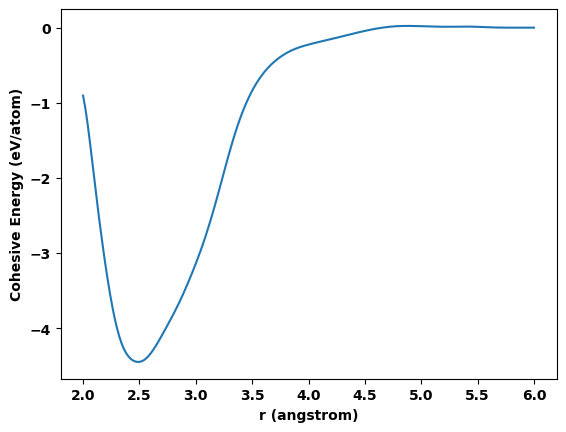

In [16]:
import matplotlib.pyplot as plt

plt.plot(r, Ecoh)
plt.xlabel(f'r ({length_unit})')
plt.ylabel(f'Cohesive Energy ({energy_unit}/atom)')

plt.show()

In [14]:
for mincell in results_dict['min_cell']:
    print('Possible minimum near:')
    print('a =', uc.get_in_units(mincell.box.a, length_unit), length_unit)
    print('b =', uc.get_in_units(mincell.box.b, length_unit), length_unit)
    print('c =', uc.get_in_units(mincell.box.c, length_unit), length_unit)
    print()

Possible minimum near:
a = 3.510660803076929 angstrom
b = 3.510660803076929 angstrom
c = 3.510660803076929 angstrom

Possible minimum near:
a = 7.376651646951118 angstrom
b = 7.376651646951118 angstrom
c = 7.376651646951118 angstrom

